In [1]:
#/kaggle/input/Kannada-MNIST/Dig-MNIST.csv - validation
#/kaggle/input/Kannada-MNIST/train.csv     - training
#/kaggle/input/Kannada-MNIST/test.csv      - test
#/kaggle/input/Kannada-MNIST/sample_submission.csv

# Library Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, f1_score

MAX_VALUE = 255

# Helper Functions

In [3]:
def breaker():
    print("\n" + 30*"-" + "\n")

def head(x, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()

def imgPlotter(x=None, idx=None, name=None):
    img = x.copy()
    img = img.reshape(28, 28)
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title("{name}_Sample_{idx}".format(name=name, idx=idx))
    plt.show()

# Data Handling

**Inputs**

In [4]:
tr_Set = pd.read_csv("/kaggle/input/Kannada-MNIST/train.csv")
ts_Set = pd.read_csv("/kaggle/input/Kannada-MNIST/test.csv")
va_Set = pd.read_csv("/kaggle/input/Kannada-MNIST/Dig-MNIST.csv")

breaker()
print("Train Set Shape :", repr(tr_Set.shape))
breaker()
print("Test Set Shape  :", repr(ts_Set.shape))
breaker()
print("Valid Set Shape :", repr(va_Set.shape))
breaker()

X_train, y_train = tr_Set.iloc[:, 1:].copy().values, tr_Set.iloc[:, 0].copy().values

X_valid, y_valid = va_Set.iloc[:, 1:].copy().values, va_Set.iloc[:, 0].copy().values

X_test  = ts_Set.iloc[:, 1:].copy().values

del tr_Set, ts_Set, va_Set


------------------------------

Train Set Shape : (60000, 785)

------------------------------

Test Set Shape  : (5000, 785)

------------------------------

Valid Set Shape : (10240, 785)

------------------------------



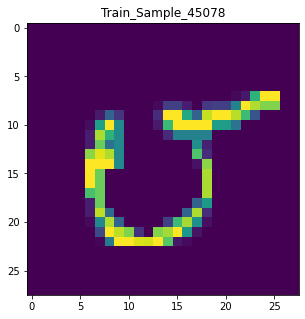

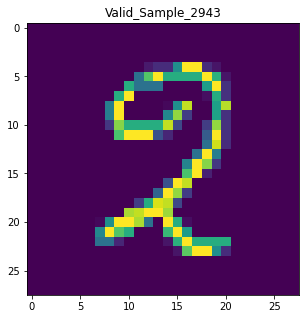

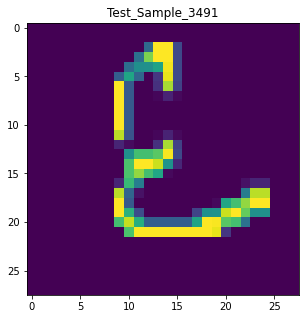

In [5]:
tr_id = r.randint(0, 60000)
ts_id = r.randint(0, 5000)
va_id = r.randint(0, 10240)

imgPlotter(X_train[tr_id], tr_id, "Train")
imgPlotter(X_valid[va_id], va_id, "Valid")
imgPlotter(X_test[ts_id], ts_id, "Test")

**Normalizing Pixel Values**

In [6]:
X_train = np.divide(X_train, MAX_VALUE)
X_valid = np.divide(X_valid, MAX_VALUE)
X_test  = np.divide(X_test, MAX_VALUE)

num_features = X_train.shape[1]

**Dataset Template**

In [7]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
        
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.LongTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

# ANN

**Config**

In [8]:
class ANN_CFG():
    tr_batch_size = 128
    va_batch_size = 128
    ts_batch_size = 128
    
    epochs = 20
    
    IL = num_features
    HL = [512, 512]
    OL = 10
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
cfg = ANN_CFG()

tr_data_setup = DS(X_train, y_train.reshape(-1,1))
va_data_setup = DS(X_valid, y_valid.reshape(-1,1))

dataloaders = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
               "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
              }
 

**Setup**

In [9]:
class MLP(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(MLP, this).__init__()
        
        this.BN1 = nn.BatchNorm1d(IL)
        this.FC1 = WN(nn.Linear(IL, HL[0]))
        
        this.BN2 = nn.BatchNorm1d(HL[0])
        this.FC2 = WN(nn.Linear(HL[0], HL[1]))
        
        this.BN3 = nn.BatchNorm1d(HL[1])
        this.FC3 = WN(nn.Linear(HL[1], OL))
        
    def getOptimizer(this):
        return optim.Adam(this.parameters(), lr=1e-3, weight_decay=0)
    
    def forward(this, x):
        x = this.BN1(x)
        x = F.relu(this.FC1(x))
        x = this.BN2(x)
        x = F.relu(this.FC2(x))
        x = this.BN3(x)
        x = F.log_softmax(this.FC3(x), dim=1)
        return x

Net = MLP(cfg.IL, cfg.HL, cfg.OL)
Net.to(cfg.device)

optimizer = Net.getOptimizer()

breaker()
print("Train Batch Size :", repr(cfg.tr_batch_size))
print("Valid Batch Size :", repr(cfg.tr_batch_size))
print("Test Batch Size  :", repr(cfg.ts_batch_size))
print("Epochs           :", repr(cfg.epochs))
print("Device Used      :", repr(cfg.device))
print("\nOptimizer        :", optimizer)
breaker()


------------------------------

Train Batch Size : 128
Valid Batch Size : 128
Test Batch Size  : 128
Epochs           : 20
Device Used      : device(type='cuda', index=0)

Optimizer        : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

------------------------------



**ANN Helpers**

In [10]:
def train_fn(model=None, optimizer=None, dataloaders=None):
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    LP = []
    
    start_time = time()
    breaker()
    for e in range(cfg.epochs):
        print("Epoch {e} processing...".format(e=e))
        epochLoss = {"train" : 0, "valid" : 0}
        for phase in ["train", "valid"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
            lossPerPass = 0
            
            for X, y in dataloaders[phase]:
                X, y = X.to(cfg.device), y.to(cfg.device)
                
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == "train"):
                    output = model(X)
                    loss   = nn.NLLLoss()(output, y.view(-1))
                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                lossPerPass += (loss.item()/y.shape[0])
            epochLoss[phase] = lossPerPass
        LP.append(epochLoss)
        if epochLoss["valid"] < bestLoss["valid"]:
            bestLoss = epochLoss
            name = "./best_model.pt"
            torch.save(model.state_dict(), name)
    
    breaker()
    print("Time Taken to train for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, e=cfg.epochs))
    breaker()
    
    return LP, name

def eval_fn(model=None, name=None, dataloader=None):
    Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
    
    model.load_state_dict(torch.load(name))
    model.eval()
    for X in dataloader:
        X = X.to(cfg.device)
        with torch.no_grad():
            logProb = model(X)
        Prob = torch.exp(logProb)
        Preds = torch.argmax(Prob, dim=1)
        Pred = torch.cat((Pred, Preds.view(-1,1)), dim=0)
    Pred = Pred[cfg.ts_batch_size:]
    return Pred.cpu().numpy().reshape(-1).astype(int)


------------------------------

Epoch 0 processing...
Epoch 1 processing...
Epoch 2 processing...
Epoch 3 processing...
Epoch 4 processing...
Epoch 5 processing...
Epoch 6 processing...
Epoch 7 processing...
Epoch 8 processing...
Epoch 9 processing...
Epoch 10 processing...
Epoch 11 processing...
Epoch 12 processing...
Epoch 13 processing...
Epoch 14 processing...
Epoch 15 processing...
Epoch 16 processing...
Epoch 17 processing...
Epoch 18 processing...
Epoch 19 processing...

------------------------------

Time Taken to train for 20 epochs : 1.45 minutes

------------------------------



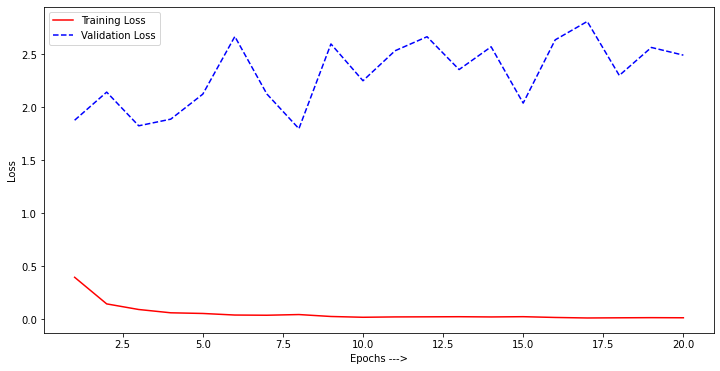

In [11]:
LP, name = train_fn(Net, optimizer, dataloaders)

LPT = []
LPV = []

for i in range(len(LP)):
    LPT.append(LP[i]["train"])
    LPV.append(LP[i]["valid"])

x_Axis = [i+1 for i in range(cfg.epochs)]

plt.figure(figsize=(12, 6))
plt.plot(x_Axis, LPT, "r", label="Training Loss")
plt.plot(x_Axis, LPV, "b--", label="Validation Loss")
plt.xlabel("Epochs --->")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [12]:
ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

y_pred = eval_fn(Net, name, ts_data)

ss = pd.read_csv("/kaggle/input/Kannada-MNIST/sample_submission.csv")
ss["label"] = y_pred
ss.to_csv("./submission.csv", index=False)